In [2]:
from __future__ import division
import pandas as pd
import numpy as np
import statsmodels.api as sm
import numpy as np
import seaborn as sns
%matplotlib inline

In [4]:
#The below contains all of the necessary splicing and renaming, etc., done during my exploratory analysis.

df = pd.read_csv("../my_hw_repo/Fangraphs_2012.csv")
df2 = pd.read_csv("../my_hw_repo/Fangraphs_2013.csv")
df3 = pd.read_csv("../my_hw_repo/Fangraphs_2014.csv")
df4 = pd.read_csv("../my_hw_repo/Fangraphs_2015.csv")
df5 = pd.read_csv("../my_hw_repo/Fangraphs_2016.csv")

batters = df.append(df2).append(df3).append(df4).append(df5)
#Combined 2012-2016 data into one dataframe called "batters"

batters = batters[["Age", "PA", "SB", "BABIP", "GB%", "LD%", "HR/FB"]]
#Kept the features I think may be relevant

batters['GB%'] = batters['GB%'].apply(lambda x: x[0:3]).astype(float)/100
batters['LD%'] = batters['LD%'].apply(lambda x: x[0:3]).astype(float)/100
batters['HR/FB'] = batters['HR/FB'].apply(lambda x: x[0:3]).astype(float)/100
#Converted the strings to floats, confirmed below by showing data types

batters = batters[batters['PA'] > 200]

batters['SB'] = batters['SB']/batters['PA'] #Change from raw SB totals to SB/PA - a proxy for speed
batters = batters[["Age", "SB", "BABIP", "GB%", "LD%", "HR/FB"]] #Deleted PA variable, not relevant anymore
batters.rename(columns = {'SB':'SBperPA', 'GB%':'GB', 'LD%':'LD', 'HR/FB':'HRperFB'}, inplace = True)
#Renamed columns for various reasons - mostly so they can be used later without % or / characters in them

batters.describe().round(3)

,Age,SBperPA,BABIP,GB,LD,HRperFB
count,1753.000,1753.000,1753.000,1753.000,1753.000,1753.000
mean,28.547,0.015,0.301,0.439,0.205,0.108
std,3.984,0.019,0.037,0.068,0.031,0.058
min,19.000,0.000,0.185,0.190,0.120,0.000
25%,26.000,0.003,0.275,0.390,0.190,0.066
50%,28.000,0.009,0.301,0.430,0.210,0.100
75%,31.000,0.021,0.324,0.480,0.220,0.140
max,42.000,0.142,0.411,0.670,0.310,0.400


In [5]:
batters = pd.get_dummies(data=batters, columns=['Age'], drop_first=True) #Since integer Age is categorical

In [7]:
from sklearn.cross_validation import train_test_split

X, y = batters.iloc[:, :].drop('BABIP', axis=1).values, batters.loc[:, 'BABIP'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

//anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [8]:
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test) #Have to make these dataframes 

In [9]:
from sklearn.preprocessing import StandardScaler

stdsc = StandardScaler()
X_train_std = pd.DataFrame(stdsc.fit_transform(X_train.iloc[:,:4])).join(X_train.iloc[:,4:])
X_test_std = pd.DataFrame(stdsc.transform(X_test.iloc[:,:4])).join(X_test.iloc[:,4:])

In [10]:
from sklearn import linear_model, metrics

model1 = linear_model.LinearRegression().fit(X_train_std, y_train)

print model1.coef_
print model1.intercept_

[ 0.00655437  0.01044925  0.01958868  0.00938843 -0.02194798  0.00547351
  0.00029066 -0.00395099 -0.00856104 -0.01278663 -0.00839789 -0.00747329
 -0.01429457 -0.0139862  -0.00992067 -0.01086467 -0.01978408 -0.01740495
 -0.02319084 -0.01576991 -0.02396921 -0.01655189 -0.02337575 -0.04187694
 -0.00685559 -0.04432792 -0.05789685]
0.313412051577


In [11]:
from sklearn import linear_model, metrics
metrics.mean_squared_error(y_test, model1.predict(X_test_std))

0.00084267149891637384

In [16]:
from sklearn.model_selection import GridSearchCV

alphas = np.logspace(-10, 10, 21)
gs = GridSearchCV(
    cv=5,
    estimator=linear_model.Ridge(),
    param_grid={'alpha': alphas, 'fit_intercept': [True, False]},
    scoring='neg_mean_squared_error')

gs.fit(X_train_std, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'alpha': array([  1.00000e-10,   1.00000e-09,   1.00000e-08,   1.00000e-07,
         1.00000e-06,   1.00000e-05,   1.00000e-04,   1.00000e-03,
         1.00000e-02,   1.00000e-01,   1.00000e+00,   1.00000e+01,
         1.00000e+02,   1.00000e+03,   1.00000e+04,   1.00000e+05,
         1.00000e+06,   1.00000e+07,   1.00000e+08,   1.00000e+09,
         1.00000e+10]), 'fit_intercept': [True, False]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

In [18]:
print gs.best_estimator_

Ridge(alpha=10.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)


In [19]:
model2 = gs.best_estimator_

In [20]:
metrics.mean_squared_error(y_test, model2.predict(X_test_std))

0.00084137153036277783

In [50]:
print model2.coef_
print model2.intercept_

[ 0.00669163  0.01029328  0.01939485  0.00939276 -0.00232896  0.01126561
  0.01127872  0.00874847  0.00473134  0.00100419  0.00507825  0.00589248
 -0.00042161 -0.00011241  0.00361522  0.00274967 -0.00528727 -0.00305776
 -0.0077511  -0.00145299 -0.00751293 -0.00170497 -0.00468393 -0.01243211
  0.00203927 -0.00507575 -0.00731281]
0.299551734021


This IS slightly lower than non-regularized. Sweet

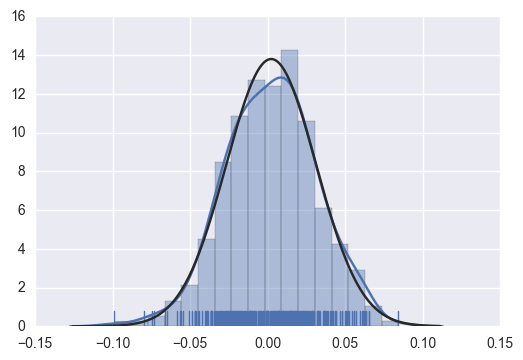

In [22]:
from scipy.stats import norm, normaltest, describe

resid = np.array(model2.predict(X_test_std)-y_test)
sns.distplot(resid, fit=norm, rug=True);

In [23]:
stat, p = normaltest(resid)
p

0.59037802491278923

Note: This looks pretty good - the residual is approximately normally distributed, and the MSE relatively low. I still want to create a random forest model, as well, for comparison's sake.

In [24]:
from sklearn.ensemble import RandomForestRegressor

model3 = RandomForestRegressor(n_estimators = 100)
model3.fit(X_train_std, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [27]:
model4 = RandomForestRegressor(random_state=30)
param_grid = { "n_estimators"      : [200,300],
           "max_features"      : [2,3,4],
           "min_samples_split" : [5, 20, 50]}
grid_search = GridSearchCV(model4, param_grid, cv=6)
grid_search.fit(X_train_std, y_train)

GridSearchCV(cv=6, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=30,
           verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [200, 300], 'max_features': [2, 3, 4], 'min_samples_split': [5, 20, 50]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [28]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=4, max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=5,
           min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
           oob_score=False, random_state=30, verbose=0, warm_start=False)

In [29]:
model5 = grid_search.best_estimator_

In [30]:
metrics.mean_squared_error(y_test, model5.predict(X_test_std))

0.00090485365263669713

In [31]:
features = columns_used
feature_importances = model5.feature_importances_

features_df = pd.DataFrame({'Features': features, 'Importance Score': feature_importances})
features_df.sort_values('Importance Score', inplace=True, ascending=False)

features_df

,Features,Importance Score
2,LD,0.302857
0,SBperPA,0.184971
1,GB,0.158170
3,HRperFB,0.158131
7,Age_23,0.014073
6,Age_22,0.013905
10,Age_26,0.013224
12,Age_28,0.013051
11,Age_27,0.012632
15,Age_31,0.011788


As expected, Line Drive % is the most important predictor. The others are less so - the least important is age, which as we know from earlier, is negatively correlated with BABIP.

In [33]:
np.zeros((1,X_train.shape[1]))
BryceHarper_2016 = pd.DataFrame(np.zeros((1,X_train.shape[1])),columns=list(columns_used))
BryceHarper_2016['Age_23'] = 1
BryceHarper_2016['SBperPA'] = 0.033
BryceHarper_2016['GB'] = 0.404
BryceHarper_2016['LD'] = 0.172
BryceHarper_2016['HRperFB'] = 0.143

print model1.predict(BryceHarper_2016) #Linear
print model2.predict(BryceHarper_2016) #Regularized linear
print model5.predict(BryceHarper_2016) #Random Forest
print "Bryce Harper's actual BABIP: .264"

[ 0.31861065]
[ 0.31735859]
[ 0.31608802]
Bryce Harper's actual BABIP: .264


In [36]:
AlbertPujols_2016 = pd.DataFrame(np.zeros((1,X_train.shape[1])),columns=list(columns_used))
AlbertPujols_2016['Age_36'] = 1
AlbertPujols_2016['SBperPA'] = 0.006
AlbertPujols_2016['GB'] = 0.439
AlbertPujols_2016['LD'] = 0.166
AlbertPujols_2016['HRperFB'] = 0.150

print model1.predict(AlbertPujols_2016) #Linear
print model2.predict(AlbertPujols_2016) #Regularized linear
print model5.predict(AlbertPujols_2016) #Random Forest
print "Albert Pujols's actual BABIP: .260"

[ 0.29872938]
[ 0.30122616]
[ 0.30654196]
Albert Pujols's actual BABIP: .260


In [37]:
JoseAltuve_2016 = pd.DataFrame(np.zeros((1,X_train.shape[1])),columns=list(columns_used))
JoseAltuve_2016['Age_26'] = 1
JoseAltuve_2016['SBperPA'] = 0.042
JoseAltuve_2016['GB'] = 0.416
JoseAltuve_2016['LD'] = 0.262
JoseAltuve_2016['HRperFB'] = 0.130

print model1.predict(JoseAltuve_2016) #Linear
print model2.predict(JoseAltuve_2016) #Regularized linear
print model5.predict(JoseAltuve_2016) #Random Forest
print "Jose Altuve's actual BABIP: .347"

[ 0.31598906]
[ 0.31549554]
[ 0.31438908]
Jose Altuve's actual BABIP: .347


In [38]:
DJLeMahieu_2016 = pd.DataFrame(np.zeros((1,X_train.shape[1])),columns=list(columns_used))
DJLeMahieu_2016['Age_27'] = 1
DJLeMahieu_2016['SBperPA'] = 0.017
DJLeMahieu_2016['GB'] = 0.506
DJLeMahieu_2016['LD'] = 0.266
DJLeMahieu_2016['HRperFB'] = 0.102

print model1.predict(DJLeMahieu_2016) #Linear
print model2.predict(DJLeMahieu_2016) #Regularized linear
print model5.predict(DJLeMahieu_2016) #Random Forest
print "DJ LeMahieu's actual BABIP: .388 - highest in MLB"

[ 0.31750572]
[ 0.31688346]
[ 0.32027136]
DJ LeMahieu's actual BABIP: .388 - highest in MLB


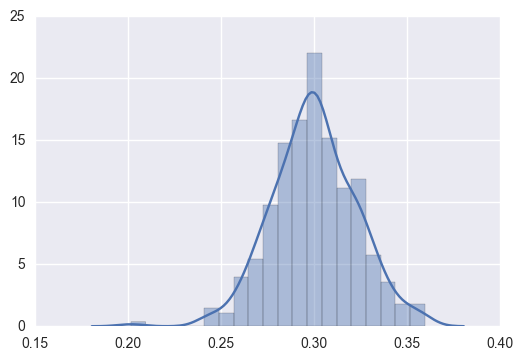

In [40]:
sns.distplot(model1.predict(X_test_std)) #Linear

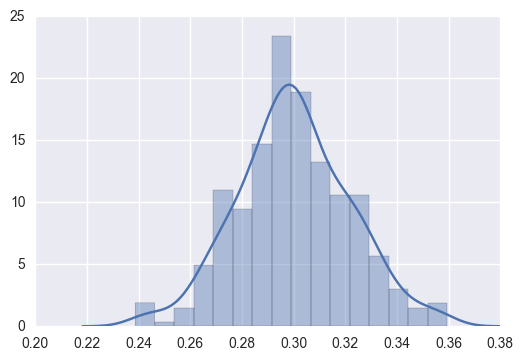

In [41]:
sns.distplot(model2.predict(X_test_std)) #Regularized Linear

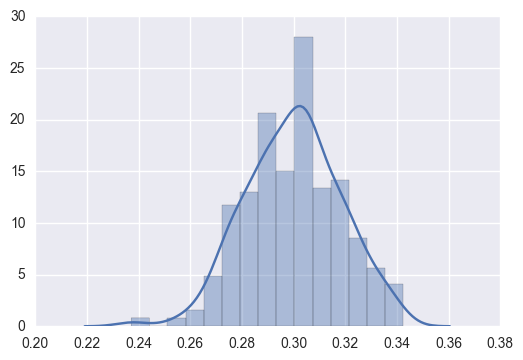

In [42]:
sns.distplot(model5.predict(X_test_std)) #Random Forest

In [45]:
y2_pred = model2.predict(X_test_std)
y5_pred = model5.predict(X_test_std)
ResultsComp = pd.DataFrame(data={'actual': y_test, 'model2': y2_pred, 'model5' : y5_pred })

In [47]:
ResultsComp

,actual,model2,model5
0,0.302,0.285266,0.287478
1,0.260,0.306843,0.297823
2,0.314,0.316663,0.314229
3,0.296,0.313298,0.309277
4,0.304,0.302778,0.300578
5,0.324,0.348935,0.320813
6,0.266,0.316424,0.310028
7,0.253,0.296796,0.304686
8,0.234,0.278205,0.280948
9,0.292,0.307596,0.307299


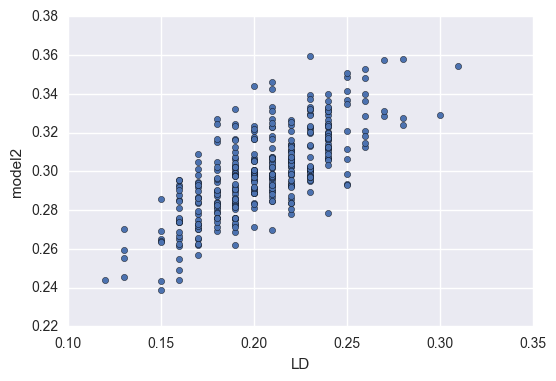

In [74]:
PlotResults = pd.DataFrame(data={'LD': X_test.ix[:,2], 'SBperPA': X_test.ix[:,0], 'model2': y2_pred })
PlotResults.plot.scatter(x='LD', y='model2');

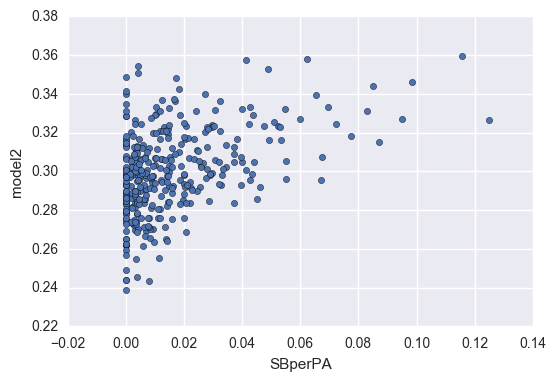

In [75]:
PlotResults.plot.scatter(x='SBperPA', y='model2');

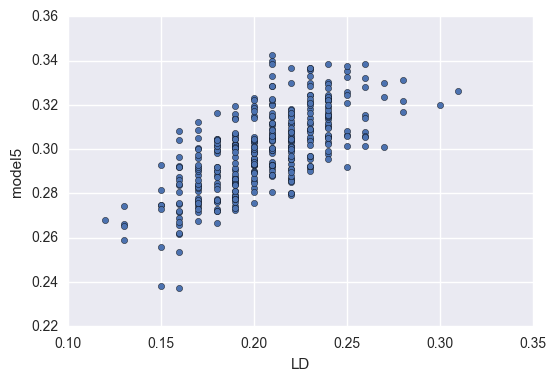

In [76]:
PlotResults = pd.DataFrame(data={'LD': X_test.ix[:,2], 'SBperPA': X_test.ix[:,0], 'model5': y5_pred })
PlotResults.plot.scatter(x='LD', y='model5');

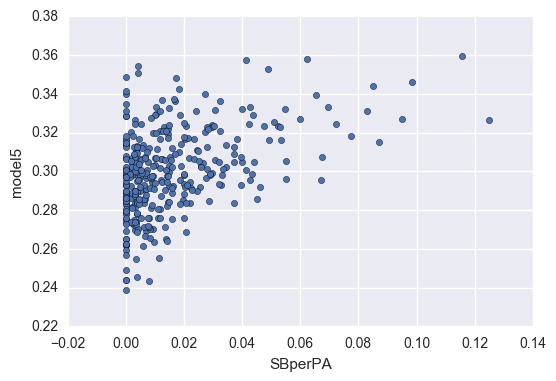

In [78]:
PlotResults.plot.scatter(x='SBperPA', y='model5');